In [3]:
from skimage import segmentation, color
from skimage.future import graph
from matplotlib import pyplot as plt
import cv2
import numpy as np
from copy import deepcopy

### 2.2 Epipolar Geometry

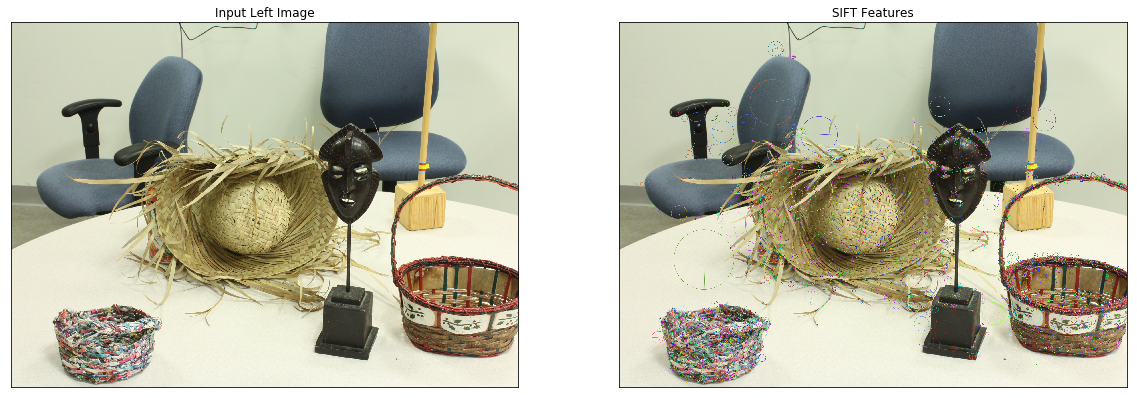

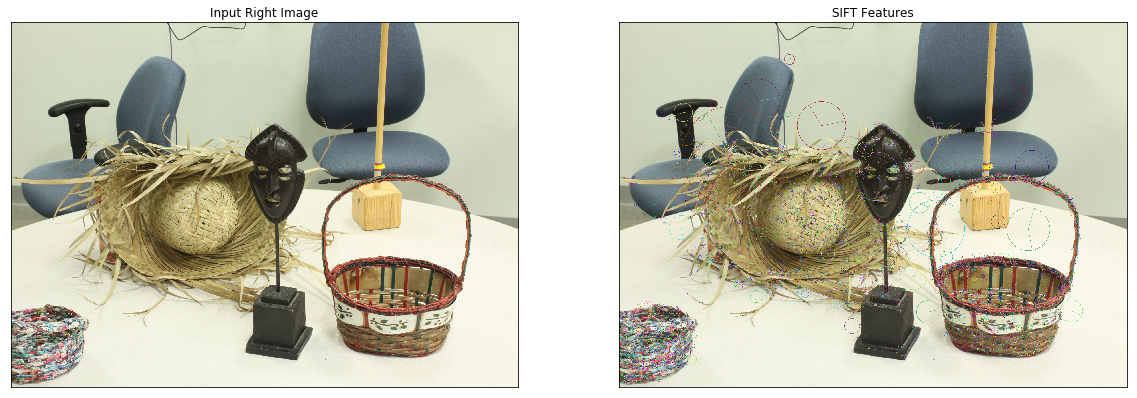

In [4]:
# load left and right images
imgL = cv2.imread("im0.png", cv2.IMREAD_COLOR)
imgR = cv2.imread("im1.png", cv2.IMREAD_COLOR)

sift = cv2.xfeatures2d.SIFT_create()
# create a Brute-Force Matcher
bfMatcher = cv2.BFMatcher(cv2.NORM_L2)

# find keypoints and descriptors with SIFT
kpL, desL = sift.detectAndCompute(imgL, None)
kpR, desR = sift.detectAndCompute(imgR, None)
        

imgL_disp = imgL.copy()
imgR_disp = imgR.copy()
cv2.drawKeypoints(imgL, kpL, imgL_disp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(imgR, kpR, imgR_disp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB))
plt.title("Input Left Image", fontsize=12), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(cv2.cvtColor(imgL_disp, cv2.COLOR_BGR2RGB))
plt.title("SIFT Features", fontsize=12), plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(cv2.cvtColor(imgR, cv2.COLOR_BGR2RGB))
plt.title("Input Right Image", fontsize=12), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(cv2.cvtColor(imgR_disp, cv2.COLOR_BGR2RGB))
plt.title("SIFT Features", fontsize=12), plt.xticks([]), plt.yticks([])
plt.show()

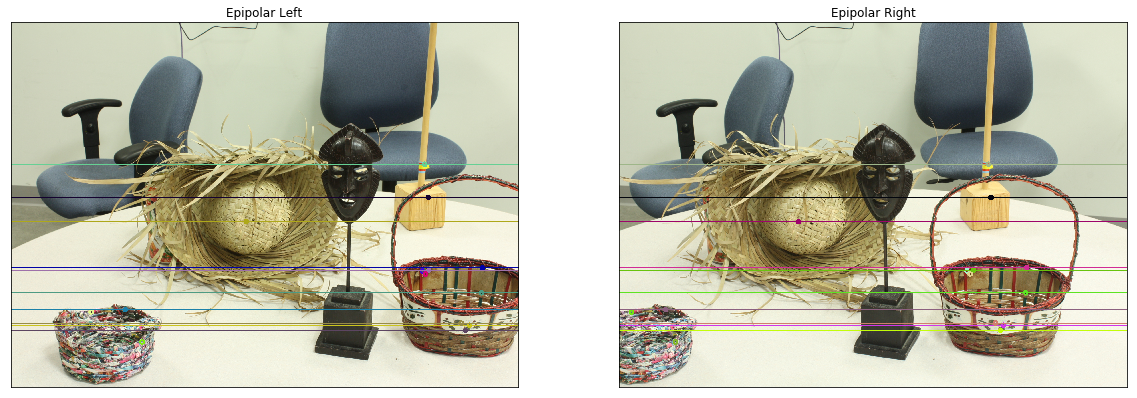

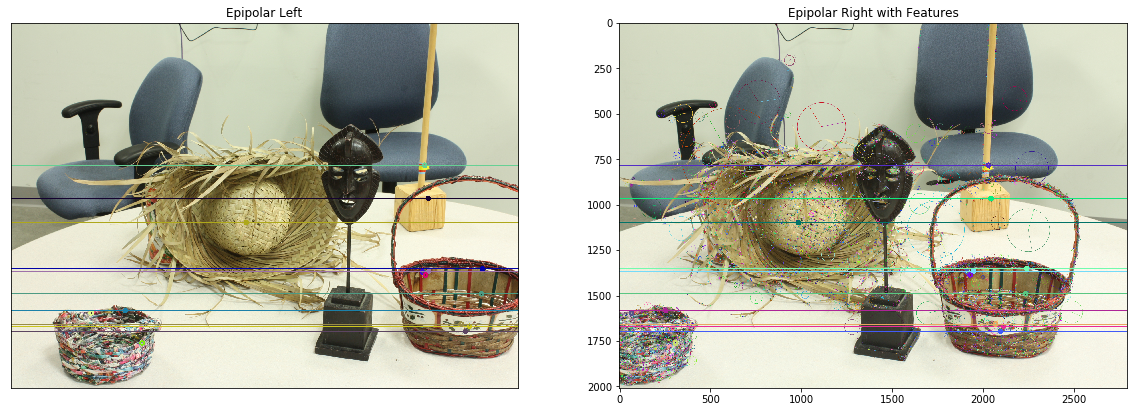

In [5]:
""" drawlines """
def drawlines(img1, img2, lines, pts1, pts2):
    """
    Draw epilines. Epilines corresponding to the points in 
    the first image are drawn on the second image.
    :param img1: image on which we draw the epilines for the points
            in img2
    :param lines: corresponding epilines
    """
    # img1 shape
    row, col, channels = img1.shape
    # Create copy so you don't modify original array
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    # for each line
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        # pick a random color
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [col, -(r[2]+r[0]*col)/r[1]])
        # draw the lines and the points
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 3)
        img1 = cv2.circle(img1, tuple(pt1), 10, color, 10)
        img2 = cv2.circle(img2, tuple(pt2), 10, color, 10)
    return img1, img2

# match descriptors (find the best two matches for each descriptor)
matches = bfMatcher.knnMatch(desL, desR, k=2)

# ratio test - store the list of best matches from both images
good = []
bad = []
ptsL = []
ptsR = []
ptsBadL = []
ptsBadR = []
for i, (m, n) in enumerate(matches):
    if m.distance < 0.16 * n.distance:
        good.append(m)
        ptsR.append(kpR[m.trainIdx].pt)
        ptsL.append(kpL[m.queryIdx].pt)
    else:
        # not good match
        bad.append(m)
        ptsBadR.append(kpR[m.trainIdx].pt)
        ptsBadL.append(kpL[m.queryIdx].pt)
        
good = good[:31]
ptsR = ptsR[:31]
ptsL = ptsL[:31]
    
# find the Fundamental Matrix
ptsL = np.int32(ptsL)
ptsR = np.int32(ptsR)
F, mask = cv2.findFundamentalMat(ptsL, ptsR, cv2.FM_LMEDS)

# Use only inliers for remaining computations
ptsL = ptsL[mask.ravel()==1]
ptsR = ptsR[mask.ravel()==1]

# find epilines
# Epilines corresponding to points in the first image is drawn on the
# second image
linesL = cv2.computeCorrespondEpilines(ptsR, 2, F)
linesL = linesL.reshape(-1, 3)
# draw lines
imgL1, imgR1 = drawlines(imgL, imgR, linesL, ptsL, ptsR)
linesR = cv2.computeCorrespondEpilines(ptsL, 1, F)
linesR = linesR.reshape(-1, 3)
# draw lines
imgR2, imgL2 = drawlines(imgR, imgL, linesR, ptsR, ptsL)
imgR2_features, imgL2_features = drawlines(imgR_disp, imgL, linesR, ptsR, ptsL)

plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(imgL1)
plt.title("Epipolar Left"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR2)
plt.title("Epipolar Right"), plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(imgL1)
plt.title("Epipolar Left"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR2_features)
plt.title("Epipolar Right with Features")
plt.show()

Earlier, we generated a set of points that weren't considered a good keypoint by our ratio algorithm. We will iterate through points within this list and select one to perform our SSD on:

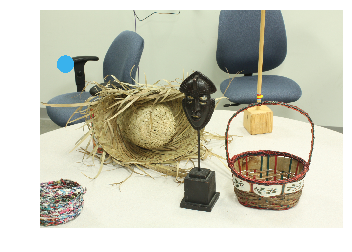

In [9]:
possible = sorted(ptsBadR, key= lambda x: x[0] + x[1])[:10]

for i in possible:
    imgT = deepcopy(imgR)
    j = [0, 0]
    j[0] = round(i[0])
    j[1] = round(i[1])
    i = j
    if i[0] > 0 and i[1] > 0 and\
        i[0] < 1000 and i[1] < 1000:
        imgT = deepcopy(imgR)
        color = tuple(np.random.randint(0, 255, 3).tolist())
        cv2.circle(imgT, tuple(i), 5, color, 150)
        plt.imshow(cv2.cvtColor(imgT, cv2.COLOR_BGR2RGB)), plt.axis("off")
        col, row = i
        plt.show()
        break

From our analysis above we choose point col = 234, row = 498 to be the point of our feature we will the perform SSD on this along the epipolar line. We take a sample below:

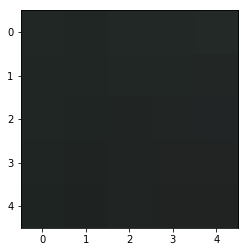

In [10]:
seg = imgR[row - 2: row + 3, col - 2: col + 3]
plt.imshow(seg)
plt.show()

We know since these are stereo images that both pairs of images sit on the same row. So we will perform SSD on just the columns:

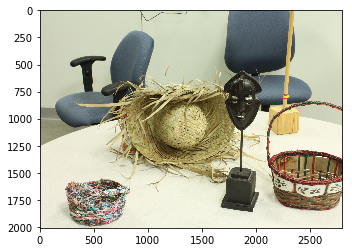

In [11]:
plt.imshow(cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB))
plt.show()

Min Updated: 
Column:  2
Min Updated: 
Column:  3
Min Updated: 
Column:  4
Min Updated: 
Column:  5
Min Updated: 
Column:  55
Min Updated: 
Column:  59
Min Updated: 
Column:  60
Min Updated: 
Column:  68
Min Updated: 
Column:  276
Min Updated: 
Column:  281
Min Updated: 
Column:  320
Min Updated: 
Column:  347
Min val was:  12


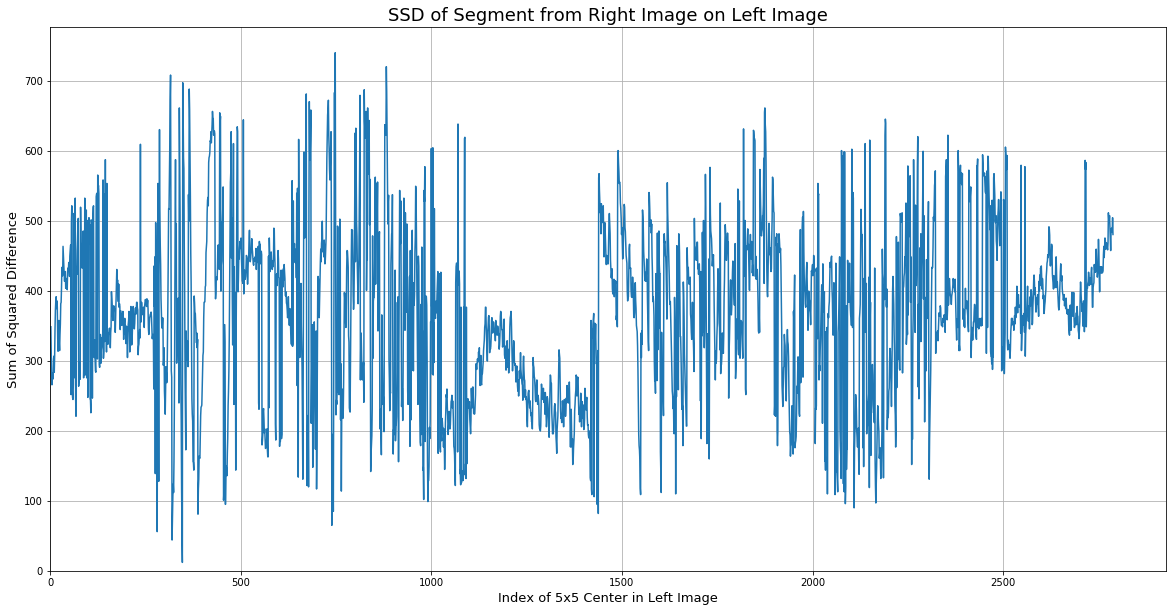

In [12]:
min_val = float('inf')
min_col = float('inf')
ssd = []
for i in range(2, len(imgL[0]) - 3):
    snip = imgL[row - 2: row +3, i - 2 : i + 3]
    i_ssd = sum(sum(sum((snip - seg)^2)))
    ssd.append(i_ssd)
    if i_ssd < min_val:
        print("Min Updated: ")
        print("Column: ", i)
        min_col = i
        min_val = i_ssd
        
print("Min val was: ", min_val)
plt.figure(figsize=(20,10))
plt.title("SSD of Segment from Right Image on Left Image", fontsize=18)
plt.xlabel("Index of 5x5 Center in Left Image", fontsize=13)
plt.ylabel("Sum of Squared Difference", fontsize=13)
plt.plot(range(2, len(imgR[0]) - 3), ssd)
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.grid(True)
plt.show()

We can see from above that our minimum point is found when our image index is at 347, we zoom out at this point to see if we are condering the correct section of the image and it looks like we are:

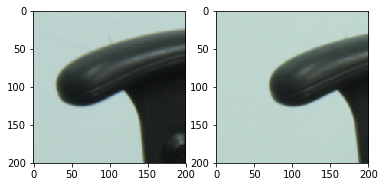

In [13]:
zoom = 100
plt.subplot(121), plt.imshow(imgL[row - zoom: row + zoom, 347 - zoom : 347 + zoom])
plt.subplot(122), plt.imshow(imgR[row - zoom: row + zoom, col - zoom: col + zoom])
plt.show()

#### Did you find exactly one matching point with lowest SSD or multiple? Is the found matching point correct one? Explain why. (2 points)
I was able to find one point with the minimum SSD however, the entire region exhibited lots of minimum SSD. This indicates to us that several points were very close to being the minimum. This can also be see in the image above as both images are quite similar.

#### Suppose you found multiple matches in the previous question. What con-straint(s) could be imposed on the matching algorithm to find a single match? (1 point)
If we were to have found multiple matches, a simple constraint that could be imposed would be the constraining the search region in our image. We know the general direction of camera and the general area where the SSD should occur so we could potentially not scan the entire image and restrain it to a certain region. 

We could also impose some constraints on the size of the image segments we look at, so instead of a 5x5 block, we might consider a 7x7 block. This could help break any potential ties in our matches and introduce scene information to help improve the results. 

#### Suppose you found exactly one match with the lowest SSD, but it is incorrect one. What constraint(s) could be imposed to find a correct match? (1 point)
If we were to have found just one match, we could impose again a constraint of location in the search region. However, in our case, where there are several minimums that are very close to each other, we would also benefit from increasing the block size across which we are performing SSD. So instead of a 5x5 block we might consider a 7x7 block. This would hopefully introduce much more of the surrounding image and create a more accurate minimum as it gives less weight to any one single pixel. 